# **RNN Models for Human Action Recognition**

Here are the models implemented, trained and analyzed in this notebook:
* LSTM

___
___

## **1. INITIALIZATION**

### *1.1. IMPORT*

In [3]:
from IPython.display import display
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tqdm import tqdm

import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random as rd
import time

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

import torch
import torch.nn as nn

In [4]:
# to fill the requirement.txt file we use the following line of code:
import session_info
session_info.show()

In [5]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("device: {}".format(device))

device: cuda


### *1.2. DATA LOADING*

In [7]:
data_dir = "../data/nturgb+d_skeletons_cleaned/"
data_files = os.listdir(data_dir)

In [9]:
actions = {}

with open("../data/actions.txt", 'r') as actions_file:
    for i,line in enumerate(actions_file.readlines()):
        actions[i] = line.replace('\n', '').split('.')[-1][1:]
    actions_file.close()

classes = np.array(list(actions.keys()))
nb_classes = classes.size

In [45]:
class HumanActionDataset(Dataset):


    """
    dataset matching sequences of 25 joints in a 3D space to action classes 
    """


    def __init__(self, data_dir, data_files):

        """
        args:
        - data_dir (string): directory with all the arrays (of size sequence_length x 25 x 3 reshaped as sequence_length x 75
        """

        self.data_dir = data_dir
        self.data_files = data_files


    def __len__(self):
        return len(self.data_files)


    def __getitem__(self, idx):
        tensor = torch.Tensor(np.load(self.data_dir + self.data_files[idx]))
        tensor = tensor.reshape((tensor.shape[0], 75))
        label = int(data_files[idx][17:-4])-1
        return (tensor, label)

Use PyTorch’s DataLoader with Variable Length Sequences for LSTM/GRU : from this [article](https://www.codefull.net/2018/11/use-pytorchs-dataloader-with-variable-length-sequences-for-lstm-gru/).

In [46]:
class PadSequence():

    def __call__(self, batch):

        # let's assume that each element in "batch" is a tuple (data, label).
        # sort the batch in the descending order
        sorted_batch = sorted(batch, key=lambda x: x[0].shape[0], reverse=True)
        
        # get each sequence and pad it
        sequences = [x[0] for x in sorted_batch]
        sequences_padded = torch.nn.utils.rnn.pad_sequence(sequences, batch_first=True)

        lengths = torch.LongTensor([len(x) for x in sequences])

        # don't forget to grab the labels of the *sorted* batch
        labels = torch.LongTensor([x[1] for x in sorted_batch])
        return sequences_padded, lengths, labels


In [106]:
HAD = HumanActionDataset(data_dir, data_files[:20000])

In [107]:
train_dataset, val_dataset = torch.utils.data.random_split(HAD, [int(0.80*len(HAD)), len(HAD)-int(0.80*len(HAD))])

In [108]:
train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=32, collate_fn=PadSequence(), shuffle=True)
val_dataloader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=32, collate_fn=PadSequence(), shuffle=True)

### *1.3 AUXILIARY FUNCTIONS*

In [109]:
def train_model(model, criterion, optimizer, nb_epochs, epoch_print_frequence):

    s = time.time()

    train_losses, val_losses, train_accs, val_accs = [], [], [], []

    for epoch in range(nb_epochs):

        running_loss_train, running_loss_val, running_acc_train, running_acc_val = 0, 0, 0, 0

        for train in [True, False]:

            if train:
                dataloader = train_dataloader
                model.train()
            else:
                dataloader = val_dataloader
                model.eval()

            for data in dataloader:
                
                inputs = data[0].to(device)
                labels_raw = data[-1]
                labels = torch.zeros((inputs.shape[0], 60))
                for i in range(len(labels_raw)):
                    labels[i][int(labels_raw[i])] = 1
                labels = labels.to(device)

                if train:
                    optimizer.zero_grad()

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                if train:
                    loss.backward()
                    optimizer.step()
                    running_loss_train += loss.item()
                    running_acc_train += torch.sum(outputs.argmax(dim=1) == labels.argmax(dim=1))
                else:
                    running_loss_val += loss.item()
                    running_acc_val += torch.sum(outputs.argmax(dim=1) == labels.argmax(dim=1))

        running_loss_train /= len(train_dataloader)
        running_loss_val /= len(val_dataloader)
        running_acc_train /= len(train_dataset)
        running_acc_val /= len(val_dataset)

        train_losses.append(running_loss_train)
        val_losses.append(running_loss_val)

        if (epoch+1) % epoch_print_frequence == 0:
            print("epochs {} ({} s) | train loss : {} | val loss : {}".format(
                epoch+1,
                int(time.time()-s),
                int(1000000*running_loss_train)/1000000,
                int(1000000*running_loss_val)/1000000
            ))
    
    return train_losses, val_losses

___

## **2. THE MODELS**

### *2.1. LSTM*

In [110]:
class LSTM0(nn.Module):

    def __init__(self, nb_classes, input_size, hidden_size, num_layers, device):

        super(LSTM0, self).__init__()

        self.num_classes = nb_classes   # number of classes
        self.num_layers = num_layers    # number of layers
        self.input_size = input_size    # input size
        self.hidden_size = hidden_size  # hidden state

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True) # lstm
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size, 128),
            nn.ReLU(),
            nn.Linear(128, nb_classes),
            nn.ReLU()
        )

    def forward(self,x):

        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) # hidden state (short memory)
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) # internal state (long memory)
        
        _, (hn, cn) = self.lstm(x, (h_0, c_0))
        hn = hn.view(-1, self.hidden_size) # reshaping the data for clasifier
        return self.classifier(hn)

In [111]:
model_LSTM0 = LSTM0(nb_classes, input_size=75, hidden_size=256, num_layers=1, device=device)
model_LSTM0.to(device)
model_LSTM0.eval()

LSTM0(
  (lstm): LSTM(75, 256, batch_first=True)
  (classifier): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=60, bias=True)
    (3): ReLU()
  )
)

In [112]:
criterion_LSTM0 = nn.CrossEntropyLoss()
optimizer_LSTM0 = torch.optim.Adam(params=model_LSTM0.parameters(), lr=1e-3)
nb_epochs = 10
epoch_print_frequence = 1

In [113]:
losses_LSTM0 = train_model(model_LSTM0, criterion_LSTM0, optimizer_LSTM0, nb_epochs, epoch_print_frequence)

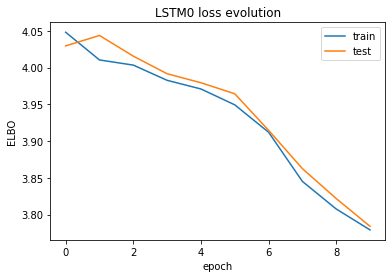

In [ ]:
plt.title("LSTM0 loss evolution")
plt.plot(losses_LSTM0[0], label="train")
plt.plot(losses_LSTM0[1], label="test")
plt.xlabel("epoch")
plt.ylabel("ELBO")
plt.legend()
plt.show()